<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==2.1.0
!pip install datasets
!pip install torchaudio=0.3.0
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00
ERROR: Invalid requirement: 'torchaudio=0.3.0'
Hint: = is not a valid operator. Did you mean == ?
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/

In [5]:
from miniai.activations import *
from miniai.learner import *
from miniai.datasets import *

from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor

import torch
from torch import nn
from torch.nn import functional as F
from torcheval.metrics import MulticlassAccuracy
import fastcore.all as fc
import matplotlib.pyplot as plt

In [6]:
dsd = load_dataset('fashion_mnist')
def new(some_data):
  def transform(some_data):
    some_data['image'] = [to_tensor(i) for i in some_data['image']]
  transform(some_data)

  return some_data

def collate_fn(some_data):
  sd = (i.values() for i in some_data)
  xs, ys = zip(*sd)
  return torch.stack(xs), torch.tensor(ys)

tds = dsd.with_transform(new)
dls = DataLoaders.from_dd(tds, 128, num_workers=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
x, y = next(iter(dls.train))

In [12]:
x.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [8]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

In [9]:
def conv(nin, nout, stride = 2, ks = 3, relu = True):
  layers = [nn.Conv2d(nin, nout, stride = stride, kernel_size = ks, padding = ks//2)]
  if relu: layers.append(nn.ReLU())
  return nn.Sequential(*layers)

def gl():
  return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, relu=False),  #1x1
        nn.Flatten()]

def gm(layers = None):
  if not layers: layers = gl()
  return nn.Sequential(*layers)

In [23]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [20]:
Callback

miniai.learner.Callback

In [28]:
model = gm()
learner = MomentumLearner(model, dls, loss_func = nn.CrossEntropyLoss(), cbs = cbs, lr = 0.3, mom = 0.9)

accuracy,loss,epoch,train
0.114,2.301,0,train
0.100,2.306,0,eval
0.098,2.308,1,train
0.100,2.308,1,eval


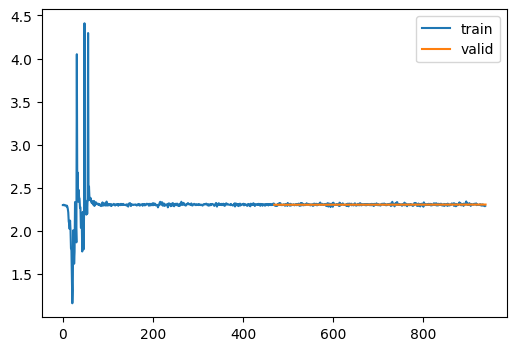

In [26]:
learner.fit(2)

In [42]:
def fit(model, epochs=1, xtra_cbs=None, lr = 0.6):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=lr, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn


In [43]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.595,1.091,0,train
0.820,0.493,0,eval


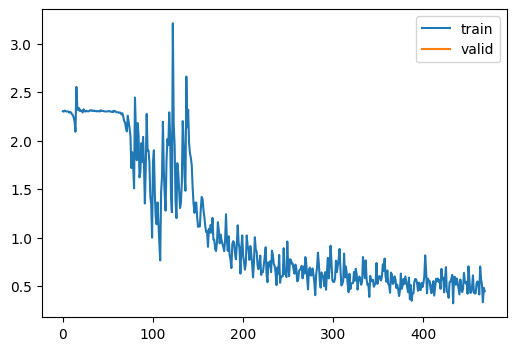

In [46]:
set_seed(1)
model = nn.Sequential(*gl())
fit(model, epochs = 1, xtra_cbs=[astats], lr = 0.7);

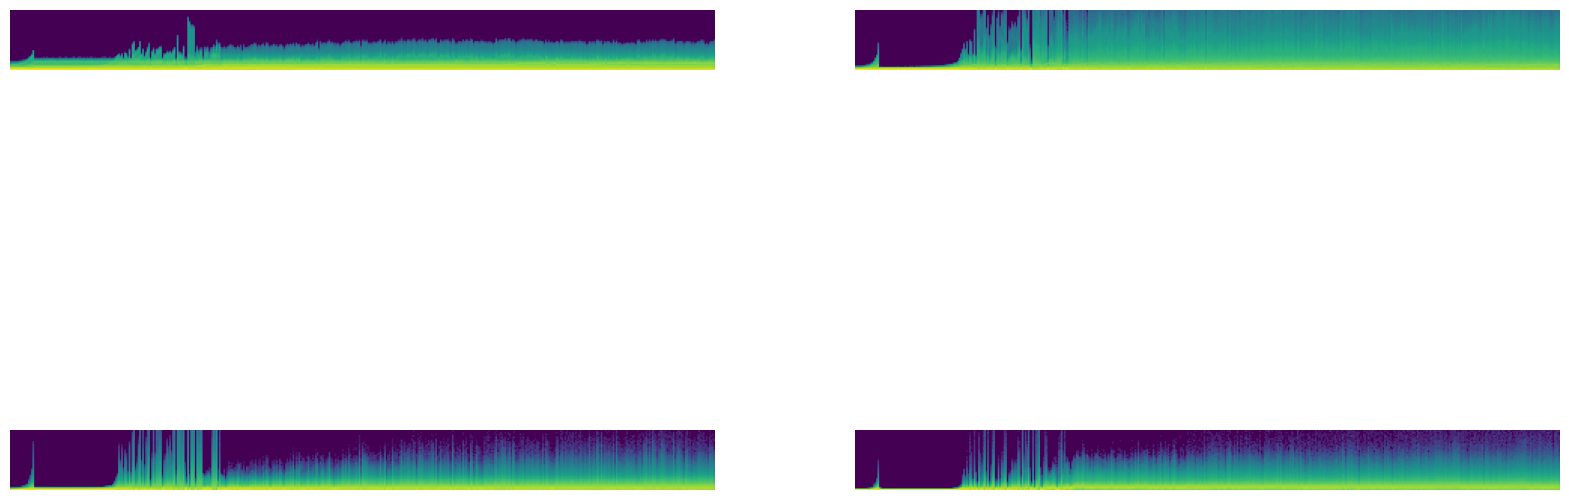

In [47]:
astats.color_dim(figsize = (20, 10))

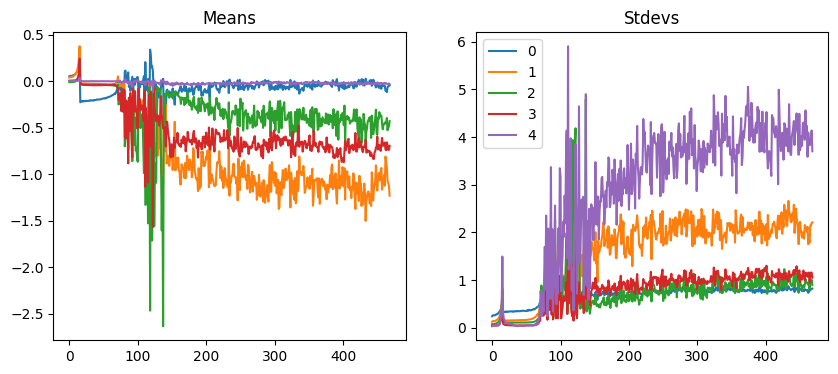

In [48]:
astats.plot_stats()

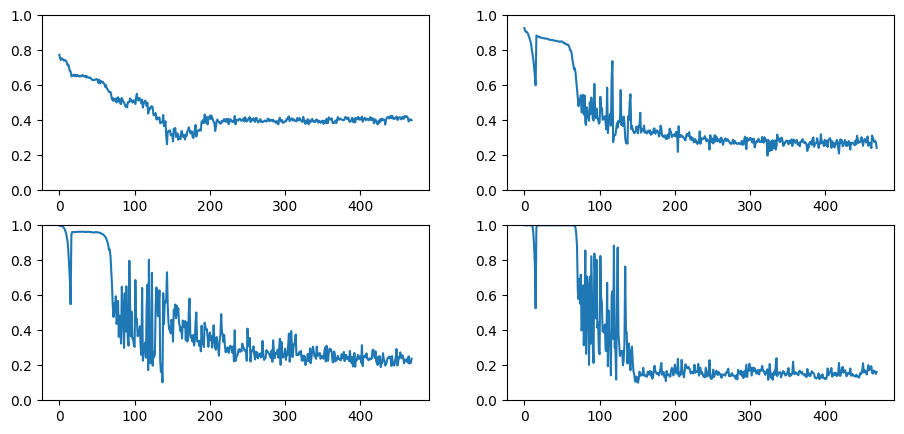

In [49]:
astats.dead_chart()

In [152]:
x = torch.randn(64, 10)
# x = (x - x.mean())/x.std()
for i in range(20): x = F.relu(x @ torch.randn(10, 10)*0.5)
x[:5], x[:5].mean(), x[:5].std()

(tensor([[1.7138, 0.3420, 0.0000, 1.1502, 0.0000, 0.0000, 1.3665, 0.0000, 0.0000,
          0.0000],
         [1.1181, 0.1895, 0.0000, 0.5705, 0.0000, 0.0000, 0.5529, 0.0000, 0.0000,
          0.0000],
         [0.6199, 0.1136, 0.0000, 0.3622, 0.0000, 0.0000, 0.3928, 0.0000, 0.0000,
          0.0000],
         [0.7601, 0.1660, 0.0000, 0.6016, 0.0000, 0.0000, 0.7754, 0.0000, 0.0000,
          0.0000],
         [1.6917, 0.3628, 0.0000, 1.3423, 0.0000, 0.0000, 1.7250, 0.0000, 0.0000,
          0.0000]]),
 tensor(0.3183),
 tensor(0.5174))

In [10]:
import math; math.sqrt(2/10)

0.4472135954999579

In [120]:
t = torch.randn(10)

In [124]:
m = t.mean()
m, t.std()

(tensor(-0.1002), tensor(0.6067))

In [125]:
(t-m).abs().mean()

tensor(0.4988)

In [126]:
t

tensor([-0.1645,  0.5711, -0.4069, -0.4752,  0.6732, -1.1665,  0.4309,  0.2207,
        -0.7819,  0.0968])

In [127]:
 t-m

tensor([-0.0643,  0.6714, -0.3067, -0.3750,  0.7734, -1.0663,  0.5311,  0.3210,
        -0.6817,  0.1971])

In [134]:
u = torch.rand_like(t)*0.5 + m

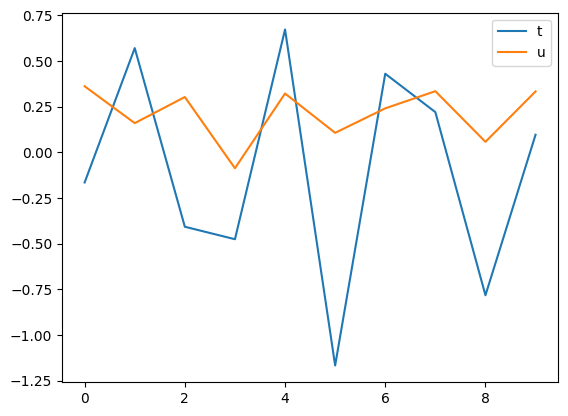

In [137]:
import matplotlib.pyplot as plt
plt.plot(t)
plt.plot(u)
plt.legend(('t', 'u'))

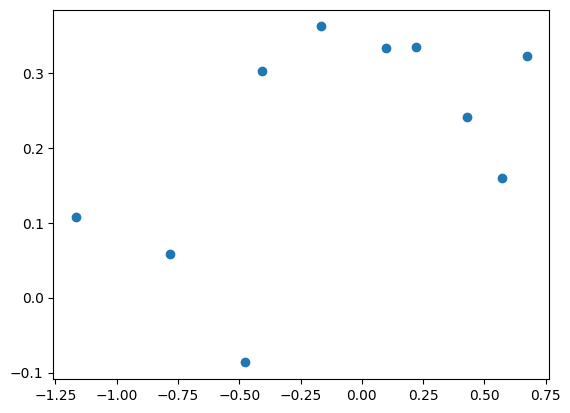

In [138]:
plt.scatter(t, u)

In [143]:
p = ((t - t.mean())*(t - t.mean())).mean()

In [146]:
p, t.mean()

(tensor(0.3313), tensor(-0.1002))

In [147]:
p*t.std() - t.mean().abs()

tensor(0.1008)

In [153]:
model = gm()

In [155]:
model.apply(lambda m: print(type(m).__name__))

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Sequential
Flatten
Sequential


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [157]:
x = torch.randn(200, 200)
print(x.mean(), x.std())
nn.init.kaiming_normal_(x)
x.mean(), x.std()

tensor(0.0011) tensor(1.0021)


(tensor(9.7181e-05), tensor(0.0997))

In [13]:
def init_weights(m):
  if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(m.weight)

In [159]:
model = gm()
model = model.apply(init_weights)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [10]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]

In [11]:
set_seed(42)

In [14]:
learner = MomentumLearner(gm().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.804,0.543,0,train
0.849,0.418,0,eval


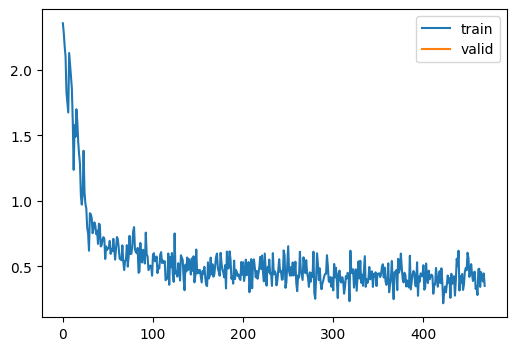

In [15]:
learner.fit(1)

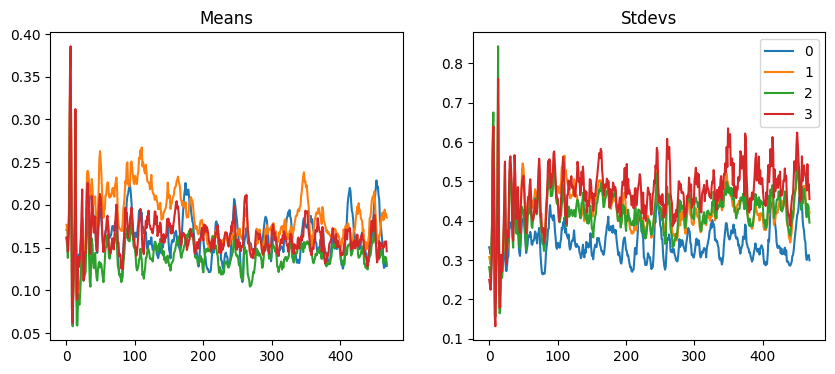

In [16]:
astats.plot_stats()

In [18]:
x, y = next(iter(dls.train))

In [19]:
x.mean(), x.std()

(tensor(0.2828), tensor(0.3565))

In [11]:
def norm_input(d):
  return ((d[0] - d[0].mean())/d[0].std(), d[1])

class NormTransformCB(Callback):
  def __init__(self, tfm): self.tfm = tfm
  def before_batch(self, learn):
    self.learn = learn
    self.learn.batch = self.tfm(self.learn.batch)

In [12]:
norm_cb = NormTransformCB(norm_input)

In [25]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
norm_cb = NormTransformCB(norm_input)
cbs = [norm_cb, DeviceCB(), metrics, ProgressCB(plot=True), astats]

accuracy,loss,epoch,train
0.809,0.527,0,train
0.838,0.428,0,eval
0.870,0.354,1,train
0.858,0.372,1,eval


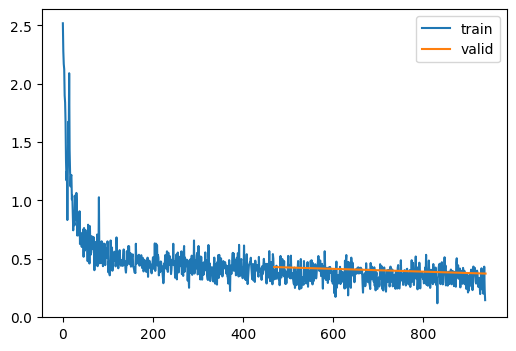

In [27]:
learner = MomentumLearner(gm().apply(init_weights), dls, F.cross_entropy, lr=0.05, cbs=cbs, mom = 0.9)
learner.fit(2)

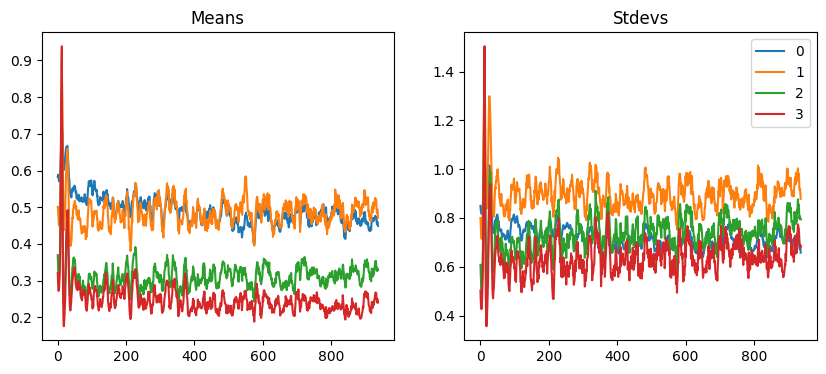

In [28]:
astats.plot_stats()

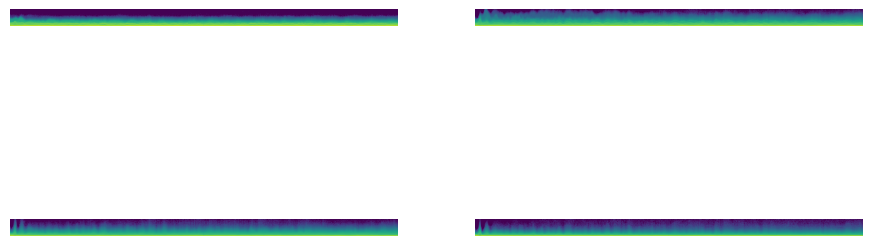

In [29]:
astats.color_dim()

In [13]:
class GeneralRelu(nn.Module):
  def __init__(self, leak = None, sub = None, max_v = None):
    super().__init__()
    fc.store_attr()

  def forward(self, x):
    x = F.relu(x) if not self.leak else F.leaky_relu(x, negative_slope = self.leak)
    if self.sub: x.sub_(self.sub)
    if self.max_v: x.clamp_max_(self.max_v)
    return x

In [14]:
from ipdb import set_trace as st
def plot_func(model):
  # st()
  with torch.no_grad():
    x = torch.linspace(-10, 10, 200)
    y = model(x)
  plt.plot(x, y)
  plt.grid(True)
  plt.axhline(y = 0, color = 'k')
  plt.axvline(x = 0, color = 'k')
  plt.show()
  # print(x, y)


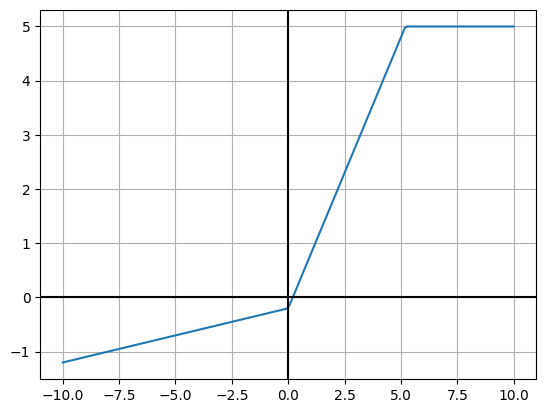

In [105]:
plot_func(GeneralRelu(0.1, 0.4, 5))

In [175]:
def conv(ni, nf, stride = 2, ks = 3, act = nn.ReLU):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2)]
  if act: layers.append(act())
  return nn.Sequential(*layers)

def get_model(act = nn.ReLU, nfs = [1, 8, 16, 32, 64], nc = 10):
  layers = [conv(nfs[i], nfs[i+1], act = act) for i in range(len(nfs)-1)]
  return nn.Sequential(*layers, conv(nfs[-1], nc, act = None), nn.Flatten())


In [15]:
def init_weights(m, leaky = 0.):
  if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Conv3d, nn.Linear)): nn.init.kaiming_normal_(m.weight, a = leaky)

In [16]:
from functools import partial
act = partial(GeneralRelu, leak = 0.1, sub = 0.4, max_v = None)
iw = partial(init_weights, leaky = 0.1)

In [200]:
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True), astats]

In [192]:
x, y = next(iter(dls.train))
yhat = model(x)
loss = F.cross_entropy(yhat, y)
loss.backward()

accuracy,loss,epoch,train
0.778,0.630,0,train
0.839,0.434,0,eval
0.858,0.384,1,train
0.857,0.385,1,eval


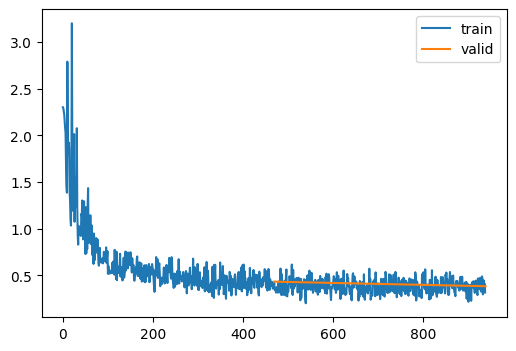

In [206]:
act = partial(GeneralRelu, leak = 0.1, sub = None, max_v = None)
iw = partial(init_weights, leaky = 0.1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True), astats]
model = get_model(act = act).apply(iw)
learner = MomentumLearner(model, dls, loss_func = F.cross_entropy, lr = 0.15, cbs = cbs, mom = 0.9)
learner.fit(2)

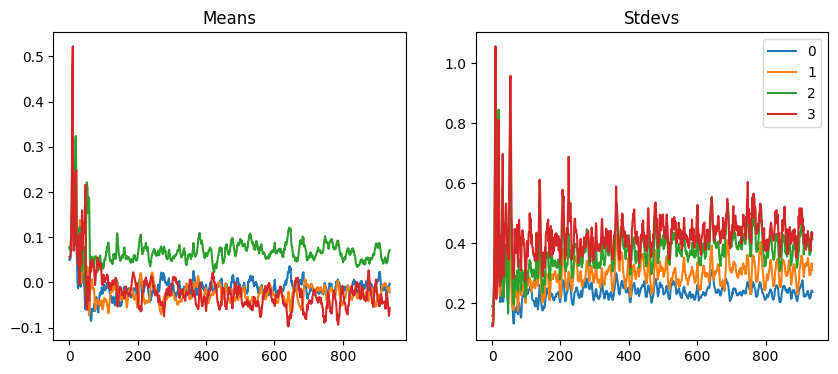

In [207]:
astats.plot_stats()

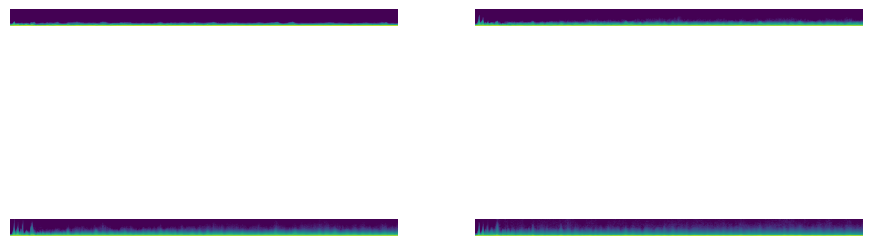

In [208]:
astats.color_dim()

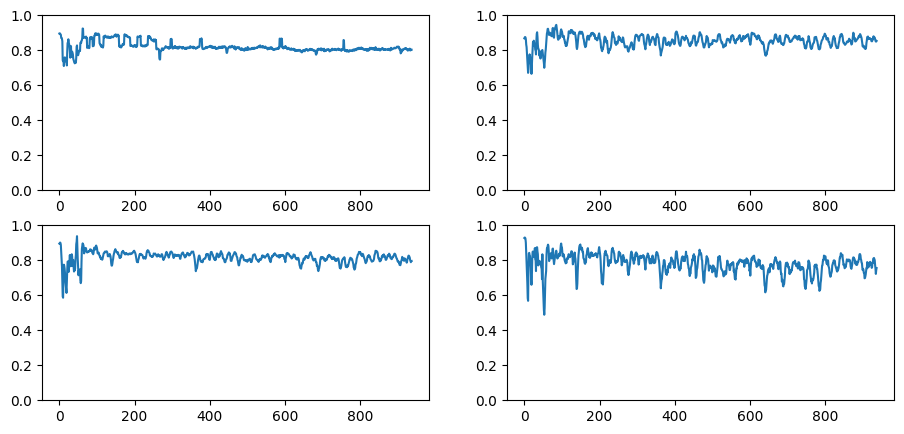

In [209]:
astats.dead_chart()

In [17]:
class LayerNorm(nn.Module):
  def __init__(self, eps = 1e-05):
    super().__init__()
    fc.store_attr()
    self.mult = nn.Parameter(torch.tensor(1.))
    self.add = nn.Parameter(torch.tensor(0.))

  def forward(self, x):
    # st()
    mean, var = x.mean((1, 2, 3), keepdim = True), x.var((1, 2, 3), keepdim = True)
    x = (x - mean)/(var + self.eps).sqrt()
    return self.mult*x + self.add


In [18]:
def conv(ni, nf, stride = 2, ks = 3, act = GeneralRelu, norm = None, bias = True):
  layers = [nn.Conv2d(ni, nf, kernel_size = ks, stride = stride, padding = ks//2, bias = bias)]
  if norm: layers.append(norm() if norm == LayerNorm else norm(nf)) # else its a batch norm.
  if act: layers.append(act())
  return nn.Sequential(*layers)

In [19]:
def get_model(act = GeneralRelu, nfs = [1, 8, 16, 32, 64], nc = 10, norm = None, bias = True):
  layers = [conv(nfs[i], nfs[i+1], act = act, norm = norm, bias = bias) for i in range(len(nfs)-1)]
  return nn.Sequential(*layers, conv(nfs[-1], nc, act = None, norm = None), nn.Flatten())

In [20]:
model = get_model(norm = LayerNorm, bias = True)

In [ ]:
model

accuracy,loss,epoch,train
0.830,0.468,0,train
0.857,0.410,0,eval
0.873,0.347,1,train
0.866,0.384,1,eval


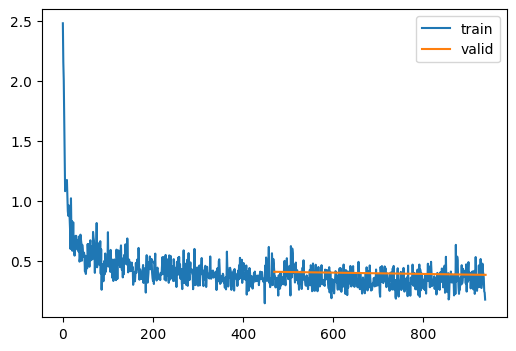

In [303]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True), astats]
model = get_model(norm = LayerNorm, bias = True, act = act).apply(iw)
learner = MomentumLearner(model, dls, loss_func = F.cross_entropy, lr = 0.15, cbs = cbs, mom = 0.9)
learner.fit(2)

In [269]:
model[-3][1].__dict__['_parameters']

OrderedDict([('mult',
              Parameter containing:
              tensor(1.8067, requires_grad=True)),
             ('add',
              Parameter containing:
              tensor(-0.9065, requires_grad=True))])

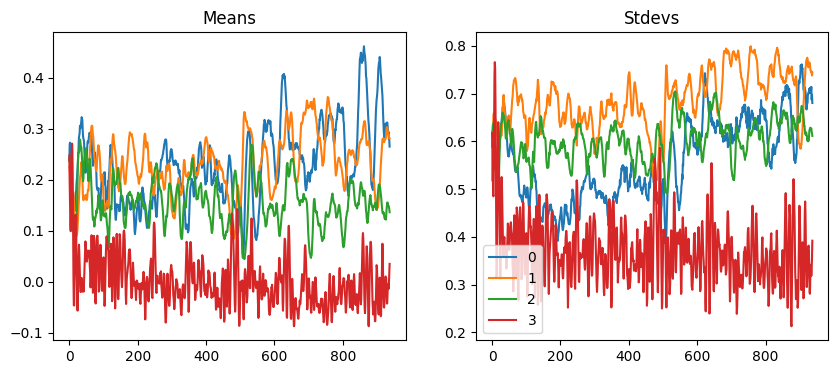

In [304]:
astats.plot_stats()

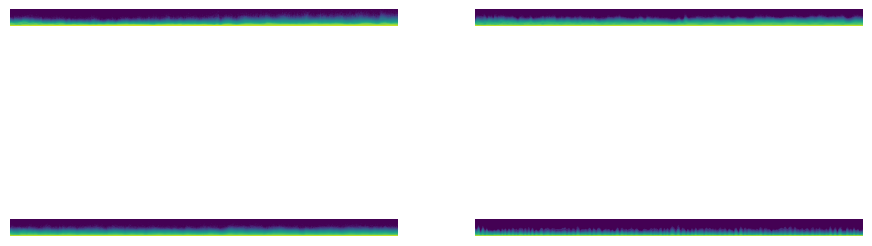

In [305]:
astats.color_dim()

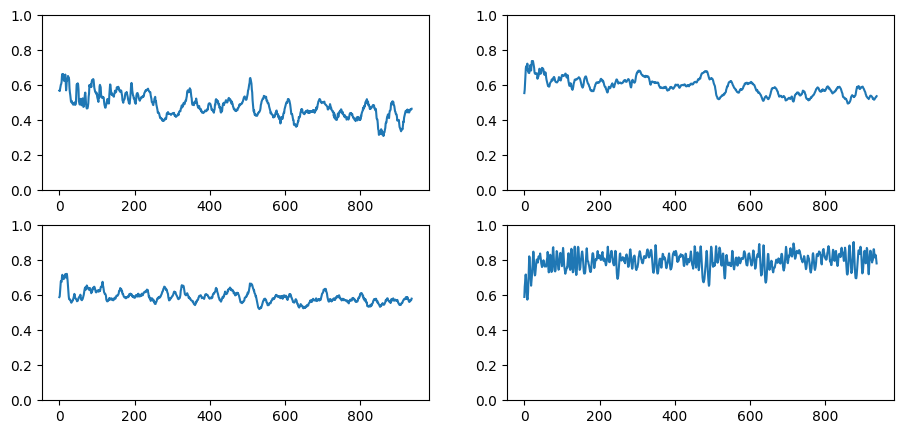

In [306]:
astats.dead_chart()

accuracy,loss,epoch,train
0.839,0.442,0,train
0.863,0.373,0,eval
0.880,0.323,1,train
0.871,0.353,1,eval


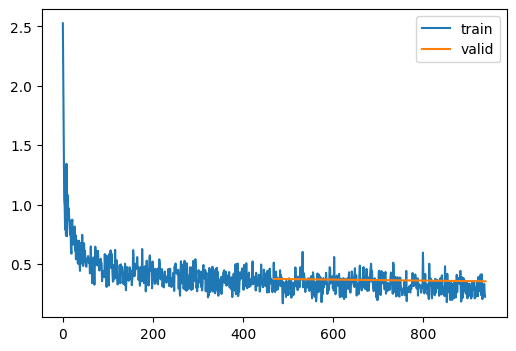

In [24]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.05, max_v = None)
iw = partial(init_weights, leaky = 0.1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True)]
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = MomentumLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, mom = 0.9)
learner.fit(2)

accuracy,loss,epoch,train
0.904,0.258,0,train
0.890,0.300,0,eval
0.910,0.242,1,train
0.891,0.297,1,eval


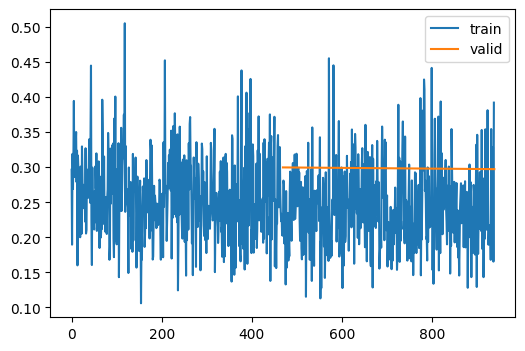

In [25]:
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True)]
learner = MomentumLearner(model, dls, loss_func = F.cross_entropy, lr = 0.05, cbs = cbs, mom = 0.9)
learner.fit(2)

In [30]:
class SGD:

  def __init__(self, params, lr = 1e-01, wd = 0.):

    self.params = list(params)
    self.lr, self.wd, self.i = lr, wd, 0
    print(wd)

  def step(self):
    with torch.no_grad():
      for p in self.params:
        if self.wd != 0.: self.reg_step(p)
        self.opt_step(p)
      self.i += 1

  def opt_step(self, p): p.sub_(self.lr*p.grad)

  def reg_step(self, p): p.sub_(p*self.lr*self.wd)

  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()



In [26]:
set_seed(42)

accuracy,loss,epoch,train
0.827,0.475,0,train
0.847,0.416,0,eval
0.875,0.341,1,train
0.859,0.388,1,eval


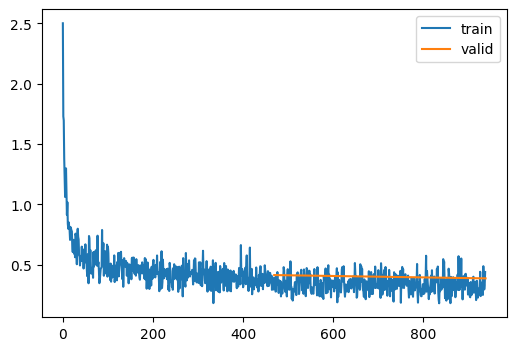

In [27]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.05, max_v = None)
iw = partial(init_weights, leaky = 0.1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True)]
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, opt_func = SGD)
learner.fit(2)

accuracy,loss,epoch,train
0.898,0.276,0,train
0.881,0.322,0,eval
0.904,0.264,1,train
0.881,0.324,1,eval


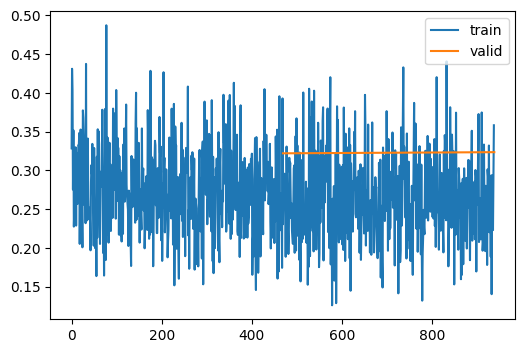

In [28]:
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.04, cbs = cbs, opt_func = SGD)
learner.fit(2)

0.01


accuracy,loss,epoch,train
0.824,0.491,0,train
0.849,0.438,0,eval
0.859,0.395,1,train
0.852,0.409,1,eval


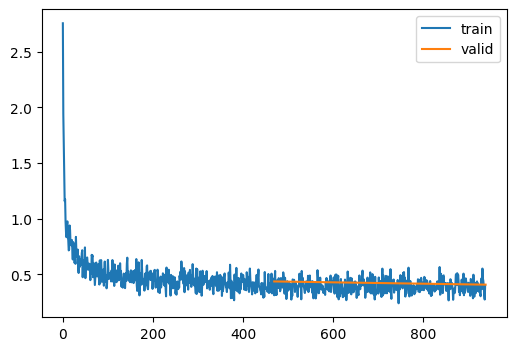

In [31]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.05, max_v = None)
iw = partial(init_weights, leaky = 0.1)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True)]
model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.2, cbs = cbs, opt_func = partial(SGD, wd = 1e-02))
learner.fit(2)

0.01


accuracy,loss,epoch,train
0.889,0.319,0,train
0.880,0.337,0,eval
0.894,0.307,1,train
0.861,0.381,1,eval


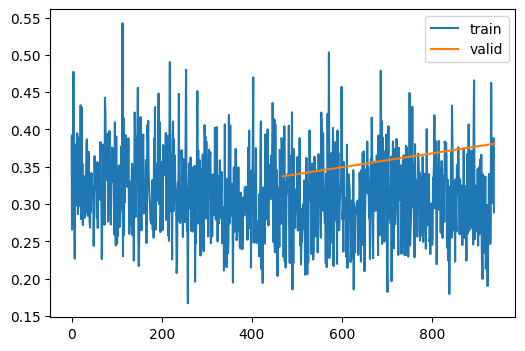

In [32]:
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.02, cbs = cbs, opt_func = partial(SGD, wd = 1e-02))
learner.fit(2)

In [37]:
class SGDMomentum(SGD):
  def __init__(self,  params, lr = 1e-01, wd = 0., mom = 0.9):
    super().__init__(params, lr, wd = wd)
    self.mom = mom

  def opt_step(self, p):
    if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p)
    p.grad_avg.lerp_(p.grad, (1-self.mom))
    p.sub_(self.lr*p.grad_avg)

0.01


accuracy,loss,epoch,train
0.826,0.490,0,train
0.817,0.513,0,eval
0.857,0.406,1,train
0.837,0.452,1,eval


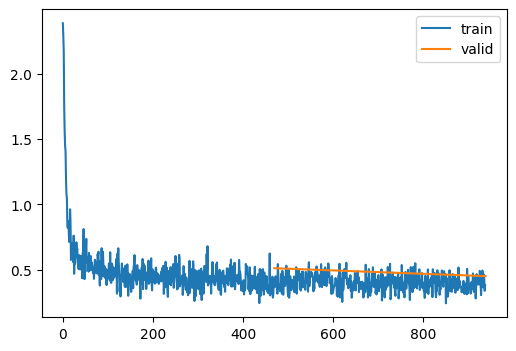

In [41]:
act = partial(GeneralRelu, leak = 0.1, sub = 0.1, max_v = None)
iw = partial(init_weights, leaky = 0.1)

astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot = True)]

model = get_model(norm = nn.BatchNorm2d, bias = False, act = act).apply(iw)
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.5, cbs = cbs, opt_func = partial(SGDMomentum, wd = 1e-02))
learner.fit(2)

0.01


accuracy,loss,epoch,train
0.887,0.322,0,train
0.880,0.336,0,eval
0.896,0.302,1,train
0.884,0.330,1,eval


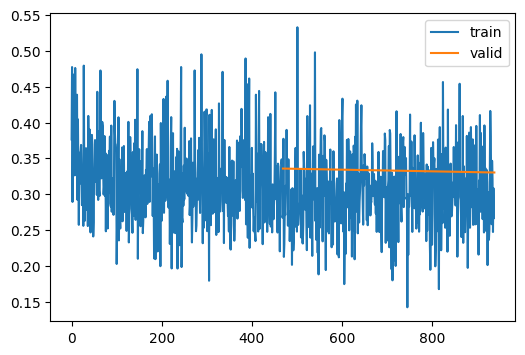

In [42]:
learner = TrainLearner(model, dls, loss_func = F.cross_entropy, lr = 0.05, cbs = cbs, opt_func = partial(SGDMomentum, wd = 1e-02))
learner.fit(2)